In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helpers
import time
import cuml, cudf, cupy
import warnings

# import preprocessing libraries and metrics
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, KFold
# from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# import models
import xgboost as xgb # XGBoost
# from cuml.linear_model import LinearRegression
# from sklearn.decomposition import PCA # Principal Component Analysis
# from sklearn.linear_model import Lasso 
# from cuml.ensemble import RandomForestRegressor # Random Forest
# from cuml.neighbors import KNeighborsRegressor # K-nearest Neighbors
# from cuml.svm import SVR # Support Vector Regressor
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostRegressor # Catboost
import lightgbm as lgb # Light Gradient-Boosting Machine

# import GPU method
# from cuml.model_selection import train_test_split
from cuml.metrics import mean_absolute_error, mean_squared_error, r2_score
from cuml.linear_model import LinearRegression, Lasso
from cuml import PCA # Principal Component Analysis
from cuml.ensemble import RandomForestRegressor # Random Forest
from cuml.neighbors import KNeighborsRegressor # K-nearest Neighbors
from cuml.svm import SVR # Support Vector Regressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

# surpress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# set plot theme
plt.style.use('ggplot')

# set dataframe display 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 10000)

In [2]:
# import training data

train_df = pd.read_csv('../data/train.csv')

train_df = helpers.clean_headers(train_df)


print(train_df.head())

  sex  length  diameter  height     weight  shucked_weight  viscera_weight  shell_weight  age
0   I  1.5250    1.1750  0.3750  28.973189       12.728926        6.647958      8.348928    9
1   I  1.1000    0.8250  0.2750  10.418441        4.521745        2.324659      3.401940    8
2   M  1.3875    1.1125  0.3750  24.777463       11.339800        5.556502      6.662133    9
3   F  1.7000    1.4125  0.5000  50.660556       20.354941       10.991839     14.996885   11
4   I  1.2500    1.0125  0.3375  23.289114       11.977664        4.507570      5.953395    8


### Normalizing data

We will normalize the ranges of numerical variables using `StandardScaler()` and categotical variables with `OneHotEncoder()`. The target variable will not be scaled. 

In [3]:
# normalize numerical variables and one hot encode categorical variables

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['length', 'diameter', 'height', 'weight','shucked_weight', 'viscera_weight', 'shell_weight']),
        ('cat', OneHotEncoder(), ['sex'])
    ]
)

# apply transformations
scaled_data = preprocessor.fit_transform(train_df)

# get column headers
column_names = preprocessor.get_feature_names_out()

# Convert transformed data back to Dataframe
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

scaled_df['age'] = train_df['age']

print(scaled_df.head()) # debug

   num__length  num__diameter  num__height  num__weight  num__shucked_weight  num__viscera_weight  num__shell_weight  cat__sex_F  cat__sex_I  cat__sex_M  age
0     0.721238       0.633982     0.292400     0.441804             0.467188             0.569186           0.453376         0.0         1.0         0.0    9
1    -0.755712      -0.840356    -0.794163    -1.025198            -0.993688            -0.978880          -0.926788         0.0         1.0         0.0    8
2     0.243401       0.370707     0.292400     0.110076             0.219924             0.178363          -0.017224         0.0         0.0         1.0    9
3     1.329394       1.634426     1.650603     2.156483             1.824616             2.124622           2.308095         1.0         0.0         0.0   11
4    -0.234435      -0.050532    -0.115061    -0.007598             0.333464            -0.197233          -0.214955         0.0         1.0         0.0    8


In [4]:
### Feature Engineering

featured_df = scaled_df.copy()

# ratio of shell weight to entire weight
featured_df['shell_weight_ratio'] = featured_df['num__shell_weight'] / featured_df['num__weight']

# meat yield
featured_df['shucked_weight_ratio'] = featured_df['num__shucked_weight'] / featured_df['num__weight']

# ratio of viscera weight to shucked weight
featured_df['vis_shucked_weight_ratio'] = featured_df['num__viscera_weight'] / featured_df['num__shucked_weight']

# General Surface Area
featured_df['surface_area'] = np.pi * 0.5 * featured_df['num__length'] * 0.5 * featured_df['num__diameter'] 




# featured_df = featured_df.drop(columns = ['weight', 'length',  'diameter'
#                                     ,'shucked_weight', 'viscera_weight', 'shell_weight'])

print(featured_df.head())

   num__length  num__diameter  num__height  num__weight  num__shucked_weight  num__viscera_weight  num__shell_weight  cat__sex_F  cat__sex_I  cat__sex_M  age  shell_weight_ratio  shucked_weight_ratio  vis_shucked_weight_ratio  surface_area
0     0.721238       0.633982     0.292400     0.441804             0.467188             0.569186           0.453376         0.0         1.0         0.0    9            1.026192              1.057454                  1.218324      0.359125
1    -0.755712      -0.840356    -0.794163    -1.025198            -0.993688            -0.978880          -0.926788         0.0         1.0         0.0    8            0.904009              0.969264                  0.985098      0.498780
2     0.243401       0.370707     0.292400     0.110076             0.219924             0.178363          -0.017224         0.0         0.0         1.0    9           -0.156476              1.997933                  0.811021      0.070867
3     1.329394       1.634426     1.6506

In [5]:
# # Scale the variables

# preprocessor = ColumnTransformer(
#     transformers = [
#         ('num', StandardScaler(), ['shell_weight_ratio', 'shucked_weight_ratio', 'vis_shucked_weight_ratio', 'surface_area']),
#         ('cat', OneHotEncoder(), ['sex'])
        
#     ]
# )

# X_preprocessed = preprocessor.fit_transform(featured_df)

# # get column headers
# column_headers = preprocessor.get_feature_names_out()


# # convert transformed data back to dataframe
# preprocessed_df = pd.DataFrame(X_preprocessed, columns=column_headers)
# preprocessed_df['age'] = featured_df['age']


In [6]:
# check datatype for preprocessed data

# create a custom function to convert the type of both dataframes into float32

def convert_float32(some_dataframe):

    columns = some_dataframe.columns.to_list()

    for col in columns:
        some_dataframe[col] = some_dataframe[col].astype('float32')

        
    print(some_dataframe.dtypes)

# call function to convert the scaled original data
convert_float32(scaled_df)


num__length            float32
num__diameter          float32
num__height            float32
num__weight            float32
num__shucked_weight    float32
num__viscera_weight    float32
num__shell_weight      float32
cat__sex_F             float32
cat__sex_I             float32
cat__sex_M             float32
age                    float32
dtype: object


In [7]:
# call function to convert the features + engineered variables
convert_float32(featured_df)

num__length                 float32
num__diameter               float32
num__height                 float32
num__weight                 float32
num__shucked_weight         float32
num__viscera_weight         float32
num__shell_weight           float32
cat__sex_F                  float32
cat__sex_I                  float32
cat__sex_M                  float32
age                         float32
shell_weight_ratio          float32
shucked_weight_ratio        float32
vis_shucked_weight_ratio    float32
surface_area                float32
dtype: object


---
## Base model
---

The base model will be used as baseline results for comparisons. 

In [8]:
#########################################
# GPU
#########################################

# convert to GPU compatible dataframe

# # convert Pandas DF to CuPy array
# cupy_array = cupy.array(scaled_df.values)

# # Create a cuDF DF from CuPy array
# cudf_df = cudf.DataFrame(cupy_array, columns = scaled_df.columns)


# Split the variables between independent and target variable
y_base = scaled_df['age']
X_base = scaled_df.drop(columns = ['age'])


# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

In [9]:
# instantiate an empty dictionary to collect model results
base_compiled_scores = {}

In [10]:
# Custom function to extract the metrics from the model. 

def get_scores(model, score_dict: dict):
    '''
    This function aims to extract the Mean Absolute Error (main), Mean Squared Error, and R2 Score
    of the models.

    The results will be added into a dictionary which will have to be instantiated outside and before
    the call of this function.
    
    
    '''
    
    # predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

   

    # MAE
    mae_train = float(mean_absolute_error(y_train, y_pred_train))
    mae_test = float(mean_absolute_error(y_test, y_pred_test))

    # MSE
    mse_train = float(mean_squared_error(y_train, y_pred_train))
    mse_test = float(mean_squared_error(y_test, y_pred_test))

    # R2
    r2_train = float(r2_score(y_train, y_pred_train))
    r2_test = float(r2_score(y_test, y_pred_test))

    print(f'''
    {str('-')*20}
    Performance Metrics: {model}
    {str('-')*20}
        
    Mean Absolute Error (train): {mae_train:.4f}
    Mean Absolute Error (test): {mae_test:.4f}

    {str('-')*50}

    Mean Squared Error (train): {mse_train:.4f}
    Mean Squared Error (test): {mse_test:.4f}

    {str('-')*50}

    Coefficient of Determination (R2) (train): {r2_train:.4f}
    Coefficient of Determination (R2) (test): {r2_test:.4f}

    {str('-')*50}

    ''')

    # add to compiled scores dict
    score_dict[str(model)] = {'MAE Train': mae_train,
                              'MAE Test': mae_test,
                              'MSE Train': mse_train,
                              'MSE Test': mse_test,
                              'R2 Train': r2_train,
                              'R2 Test': r2_test}
    
    # return compiled_scores


In [11]:
%%time
# Random Forest

rf = RandomForestRegressor()
rf_model = rf.fit(X_train, y_train)

get_scores(rf_model, base_compiled_scores)


    --------------------
    Performance Metrics: RandomForestRegressor()
    --------------------
        
    Mean Absolute Error (train): 1.0147
    Mean Absolute Error (test): 1.4241

    --------------------------------------------------

    Mean Squared Error (train): 1.9957
    Mean Squared Error (test): 4.2413

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.8015
    Coefficient of Determination (R2) (test): 0.5838

    --------------------------------------------------

    
CPU times: user 8.26 s, sys: 1.64 s, total: 9.91 s
Wall time: 2.45 s


In [12]:
%%time

# K Nearest Neighbours

knn = KNeighborsRegressor()

knn_model = knn.fit(X_train, y_train)

get_scores(knn, base_compiled_scores)


    --------------------
    Performance Metrics: KNeighborsRegressor()
    --------------------
        
    Mean Absolute Error (train): 1.2691
    Mean Absolute Error (test): 1.5430

    --------------------------------------------------

    Mean Squared Error (train): 3.3660
    Mean Squared Error (test): 5.0040

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.6652
    Coefficient of Determination (R2) (test): 0.5090

    --------------------------------------------------

    
CPU times: user 208 ms, sys: 37.3 ms, total: 245 ms
Wall time: 261 ms


In [13]:
%%time

svr = SVR()

svr_model = svr.fit(X_train, y_train)

get_scores(svr_model, base_compiled_scores)


    --------------------
    Performance Metrics: SVR()
    --------------------
        
    Mean Absolute Error (train): 1.3769
    Mean Absolute Error (test): 1.3821

    --------------------------------------------------

    Mean Squared Error (train): 4.3902
    Mean Squared Error (test): 4.3799

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.5634
    Coefficient of Determination (R2) (test): 0.5702

    --------------------------------------------------

    
CPU times: user 2.77 s, sys: 1.07 s, total: 3.85 s
Wall time: 3.92 s


In [14]:
%%time

# Catboost

cat = CatBoostRegressor(task_type = 'GPU',
                        iterations = 1000,
                        learning_rate = 0.1,
                        verbose = False)

cat_model = cat.fit(X_train, y_train)

get_scores(cat_model, base_compiled_scores)


    --------------------
    Performance Metrics: <catboost.core.CatBoostRegressor object at 0x7fb9b141d750>
    --------------------
        
    Mean Absolute Error (train): 1.3070
    Mean Absolute Error (test): 1.4066

    --------------------------------------------------

    Mean Squared Error (train): 3.5155
    Mean Squared Error (test): 4.1575

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.6503
    Coefficient of Determination (R2) (test): 0.5921

    --------------------------------------------------

    
CPU times: user 10.1 s, sys: 3.89 s, total: 14 s
Wall time: 8.73 s


In [15]:
%%time

# Light Gradient Boosting Machine

params = {'objective': 'regression',
          'metric': 'mae',
          'boosting_type': 'gbdt', 
          'num_leaves': 31,
          'learning_rate': 0.1,
          'seed': 42,
          'force_col_wise': True
}

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

light_model = lgb.train(params, train_data, 100, valid_sets=[test_data])


light_pred_train = light_model.predict(X_train)
light_pred_test = light_model.predict(X_test)

# MAE
mae_train = float(mean_absolute_error(y_train, light_pred_train))
mae_test = float(mean_absolute_error(y_test, light_pred_test))

# MSE
mse_train = float(mean_squared_error(y_train, light_pred_train))
mse_test = float(mean_squared_error(y_test, light_pred_test))

# R2
r2_train = float(r2_score(y_train, light_pred_train))
r2_test = float(r2_score(y_test, light_pred_test))

print(f'''
{str('-')*20}
Performance Metrics: lightoost
{str('-')*20}
    
Mean Absolute Error (train): {mae_train:.4f}
Mean Absolute Error (test): {mae_test:.4f}

{str('-')*50}

Mean Squared Error (train): {mse_train:.4f}
Mean Squared Error (test): {mse_test:.4f}

{str('-')*50}

Coefficient of Determination (R2) (train): {r2_train:.4f}
Coefficient of Determination (R2) (test): {r2_test:.4f}

{str('-')*50}

''')

# add to compiled scores dict
base_compiled_scores[str('lightGBM')] = {'MAE Train': mae_train,
                        'MAE Test': mae_test,
                        'MSE Train': mse_train,
                        'MSE Test': mse_test,
                        'R2 Train': r2_train,
                        'R2 Test': r2_test}

[LightGBM] [Info] Total Bins 1324
[LightGBM] [Info] Number of data points in the train set: 59240, number of used features: 10
[LightGBM] [Info] Start training from score 9.970172

--------------------
Performance Metrics: lightoost
--------------------
    
Mean Absolute Error (train): 1.3500
Mean Absolute Error (test): 1.4065

--------------------------------------------------

Mean Squared Error (train): 3.8081
Mean Squared Error (test): 4.1518

--------------------------------------------------

Coefficient of Determination (R2) (train): 0.6212
Coefficient of Determination (R2) (test): 0.5926

--------------------------------------------------


CPU times: user 15.5 s, sys: 1.34 s, total: 16.8 s
Wall time: 1.46 s


#### XGBoost

In order to run XGBoost on the GPU, the data has to be saved in the GPU memory. The custom function will raise an error so we will have to code the results in this cell block.

In [16]:
%%time

# XGBoost

# Convert data to GPU dataframes
X_train_gpu, y_train_gpu = cudf.DataFrame(X_train), cudf.Series(y_train)
X_test_gpu, y_test_gpu = cudf.DataFrame(X_test), cudf.Series(y_test)

# Create DMatrix
dtrain = xgb.DMatrix(X_train_gpu, label=y_train_gpu)
dtest = xgb.DMatrix(X_test_gpu, label=y_test_gpu)


# xgb_model = xgb.XGBRegressor(
#             device = 'cuda',  # Using GPU
#             booster = 'gbtree',
#             random_state=42
#             )

params = {'device': 'cuda',
          'booster': 'gbtree',
          'random_state': 42}

xgb_model = xgb.train(params, dtrain, num_boost_round = 100)

xg_pred_train = xgb_model.predict(dtrain)
xg_pred_test = xgb_model.predict(dtest)

# MAE
mae_train = float(mean_absolute_error(y_train_gpu, xg_pred_train))
mae_test = float(mean_absolute_error(y_test_gpu, xg_pred_test))

# MSE
mse_train = float(mean_squared_error(y_train_gpu, xg_pred_train))
mse_test = float(mean_squared_error(y_test_gpu, xg_pred_test))

# R2
r2_train = float(r2_score(y_train_gpu, xg_pred_train))
r2_test = float(r2_score(y_test_gpu, xg_pred_test))

print(f'''
{str('-')*20}
Performance Metrics: XGBoost
{str('-')*20}
    
Mean Absolute Error (train): {mae_train:.4f}
Mean Absolute Error (test): {mae_test:.4f}

{str('-')*50}

Mean Squared Error (train): {mse_train:.4f}
Mean Squared Error (test): {mse_test:.4f}

{str('-')*50}

Coefficient of Determination (R2) (train): {r2_train:.4f}
Coefficient of Determination (R2) (test): {r2_test:.4f}

{str('-')*50}

''')

# add to compiled scores dict
base_compiled_scores[str('XGBoost')] = {'MAE Train': mae_train,
                        'MAE Test': mae_test,
                        'MSE Train': mse_train,
                        'MSE Test': mse_test,
                        'R2 Train': r2_train,
                        'R2 Test': r2_test}




--------------------
Performance Metrics: XGBoost
--------------------
    
Mean Absolute Error (train): 1.2547
Mean Absolute Error (test): 1.4212

--------------------------------------------------

Mean Squared Error (train): 3.2330
Mean Squared Error (test): 4.2485

--------------------------------------------------

Coefficient of Determination (R2) (train): 0.6784
Coefficient of Determination (R2) (test): 0.5831

--------------------------------------------------


CPU times: user 3.11 s, sys: 506 ms, total: 3.61 s
Wall time: 1.08 s


In [20]:
base_compiled_scores_df = pd.DataFrame(base_compiled_scores)

list_of_models = ['Random Forest', 'K-Nearest Neighbours',
                  'Support Vector Machine', 'Catboost', 'LightGBM', 'XGBoost']

# rename the name of models in df
base_compiled_scores_df.columns = list_of_models[:len(base_compiled_scores_df.columns)]

print(base_compiled_scores_df)
    

           Random Forest  K-Nearest Neighbours  Support Vector Machine  Catboost  LightGBM   XGBoost
MAE Train       1.014681              1.269082                1.376891  1.306964  1.350002  1.254670
MAE Test        1.424126              1.542975                1.382103  1.406616  1.406531  1.421196
MSE Train       1.995749              3.366018                4.390152  3.515494  3.808062  3.232952
MSE Test        4.241337              5.004041                4.379949  4.157457  4.151804  4.248526
R2 Train        0.801501              0.665213                0.563351  0.650345  0.621246  0.678447
R2 Test         0.583839              0.509002                0.570238  0.592069  0.592624  0.583133


### Hypertuning XGBoost

In [21]:
%%time

# convert to GPU compatible dataframe

# # convert Pandas DF to CuPy array
cupy_array = cupy.array(scaled_df.values)

# Create a cuDF DF from CuPy array
cudf_df = cudf.DataFrame(cupy_array, columns = scaled_df.columns)

# # Split the variables between independent and target variable
y_cudf = cudf_df['age']
X_cudf = cudf_df.drop(columns = ['age'])

# Conversion to DMatrix
def convert_to_dmatrix(X, y):
    return xgb.DMatrix(data=X, label=y)

# Define the objective function
def objective(space):
    mae_scores = []
    try: 
        # K-Fold Cross-Validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        for train_index, test_index in kf.split(X_cudf):
            X_train, X_test = X_cudf.iloc[train_index], X_cudf.iloc[test_index]
            y_train, y_test = y_cudf.iloc[train_index], y_cudf.iloc[test_index]
            
            dtrain = convert_to_dmatrix(X_train, y_train)
            dtest = convert_to_dmatrix(X_test, y_test)
            
            params = {
                'max_depth': int(space['max_depth']),
                'gamma': space['gamma'],
                'subsample': space['subsample'],
                'eta': space['eta'],
                'min_child_weight': space['min_child_weight'],
                'device': 'cuda',                                # state GPU
                'objective': 'reg:squarederror',
                'eval_metric': 'mae'
            }
            
            model = xgb.train(params, dtrain, evals=[(dtrain, 'train')], num_boost_round=100, verbose_eval=False)
            preds = model.predict(dtest)

            mae = mean_absolute_error(y_test, preds)
            mae_scores.append(mae)
        
        # average_mae = np.mean(mae_scores)
        mae_scores_gpu = cupy.array(mae_scores)
        average_mae = cupy.mean(mae_scores_gpu).get()
        return {'loss': average_mae, 'status': STATUS_OK}
    
    except Exception as e:
        print(f"Error with parameters {space}: {str(e)}")
        return {'loss': float('inf'), 'status': STATUS_FAIL}  # Use a large loss to denote failure

# Hyperparameter space
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
    'eta': hp.uniform('eta', 0.01, 0.3)
}

# Optimization Algorithm
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,  # Change as per computational resources
            trials=trials)

print("Best hyperparameters:", best)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [03:50<00:00,  4.62s/trial, best loss: 1.4011085033416748]
Best hyperparameters: {'eta': 0.0803596624700447, 'gamma': 0.3709708289809867, 'max_depth': 6.0, 'min_child_weight': 6.0, 'subsample': 0.7841234329075351}
CPU times: user 11min 45s, sys: 1min 15s, total: 13min
Wall time: 3min 51s


---
## With Featured Engineered Features
---

In [22]:
# Split the variables between independent and target variable
y_base = featured_df['age']
X_base = featured_df.drop(columns = ['age'])


# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

In [23]:
# instantiate an empty dictionary to collect model results
featured_compiled_results= {}

In [24]:
%%time
# Random Forest

rf = RandomForestRegressor()
rf_model = rf.fit(X_train, y_train)

get_scores(rf_model, featured_compiled_results)


    --------------------
    Performance Metrics: RandomForestRegressor()
    --------------------
        
    Mean Absolute Error (train): 0.9897
    Mean Absolute Error (test): 1.4213

    --------------------------------------------------

    Mean Squared Error (train): 1.8788
    Mean Squared Error (test): 4.2128

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.8131
    Coefficient of Determination (R2) (test): 0.5866

    --------------------------------------------------

    
CPU times: user 9.21 s, sys: 1.61 s, total: 10.8 s
Wall time: 1.97 s


In [25]:
%%time

# K Nearest Neighbours

knn = KNeighborsRegressor()

knn_model = knn.fit(X_train, y_train)

get_scores(knn, featured_compiled_results)


    --------------------
    Performance Metrics: KNeighborsRegressor()
    --------------------
        
    Mean Absolute Error (train): 1.2825
    Mean Absolute Error (test): 1.5616

    --------------------------------------------------

    Mean Squared Error (train): 3.4351
    Mean Squared Error (test): 5.0660

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.6583
    Coefficient of Determination (R2) (test): 0.5029

    --------------------------------------------------

    
CPU times: user 240 ms, sys: 2.53 ms, total: 243 ms
Wall time: 250 ms


In [26]:
%%time

svr = SVR()

svr_model = svr.fit(X_train, y_train)

get_scores(svr_model, featured_compiled_results)


    --------------------
    Performance Metrics: SVR()
    --------------------
        
    Mean Absolute Error (train): 1.4485
    Mean Absolute Error (test): 1.4572

    --------------------------------------------------

    Mean Squared Error (train): 4.9817
    Mean Squared Error (test): 5.0043

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.5045
    Coefficient of Determination (R2) (test): 0.5090

    --------------------------------------------------

    
CPU times: user 2.44 s, sys: 1.18 s, total: 3.62 s
Wall time: 3.7 s


In [27]:
%%time

# Catboost

cat = CatBoostRegressor(task_type = 'GPU',
                        iterations = 1000,
                        learning_rate = 0.1,
                        verbose = False)

cat_model = cat.fit(X_train, y_train)

get_scores(cat_model, featured_compiled_results)


    --------------------
    Performance Metrics: <catboost.core.CatBoostRegressor object at 0x7fb9b13dce80>
    --------------------
        
    Mean Absolute Error (train): 1.2953
    Mean Absolute Error (test): 1.4100

    --------------------------------------------------

    Mean Squared Error (train): 3.4263
    Mean Squared Error (test): 4.1665

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.6592
    Coefficient of Determination (R2) (test): 0.5912

    --------------------------------------------------

    
CPU times: user 15.2 s, sys: 5.36 s, total: 20.5 s
Wall time: 12.4 s


In [28]:
%%time

# Light Gradient Boosting Machine

params = {'objective': 'regression',
          'metric': 'mae',
          'boosting_type': 'gbdt', 
          'num_leaves': 31,
          'learning_rate': 0.1,
          'seed': 42,
          'force_col_wise': True
}

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

light_model = lgb.train(params, train_data, 100, valid_sets=[test_data])


light_pred_train = light_model.predict(X_train)
light_pred_test = light_model.predict(X_test)

# MAE
mae_train = float(mean_absolute_error(y_train, light_pred_train))
mae_test = float(mean_absolute_error(y_test, light_pred_test))

# MSE
mse_train = float(mean_squared_error(y_train, light_pred_train))
mse_test = float(mean_squared_error(y_test, light_pred_test))

# R2
r2_train = float(r2_score(y_train, light_pred_train))
r2_test = float(r2_score(y_test, light_pred_test))

print(f'''
{str('-')*20}
Performance Metrics: lightoost
{str('-')*20}
    
Mean Absolute Error (train): {mae_train:.4f}
Mean Absolute Error (test): {mae_test:.4f}

{str('-')*50}

Mean Squared Error (train): {mse_train:.4f}
Mean Squared Error (test): {mse_test:.4f}

{str('-')*50}

Coefficient of Determination (R2) (train): {r2_train:.4f}
Coefficient of Determination (R2) (test): {r2_test:.4f}

{str('-')*50}

''')

# add to compiled scores dict
featured_compiled_results[str('lightGBM')] = {'MAE Train': mae_train,
                                                'MAE Test': mae_test,
                                                'MSE Train': mse_train,
                                                'MSE Test': mse_test,
                                                'R2 Train': r2_train,
                                                'R2 Test': r2_test}

[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 59240, number of used features: 14
[LightGBM] [Info] Start training from score 9.970172

--------------------
Performance Metrics: lightoost
--------------------
    
Mean Absolute Error (train): 1.3433
Mean Absolute Error (test): 1.4087

--------------------------------------------------

Mean Squared Error (train): 3.7643
Mean Squared Error (test): 4.1634

--------------------------------------------------

Coefficient of Determination (R2) (train): 0.6256
Coefficient of Determination (R2) (test): 0.5915

--------------------------------------------------


CPU times: user 1min 25s, sys: 7.19 s, total: 1min 32s
Wall time: 7.81 s


In [29]:
%%time

# XGBoost

# Convert data to GPU dataframes
X_train_gpu, y_train_gpu = cudf.DataFrame(X_train), cudf.Series(y_train)
X_test_gpu, y_test_gpu = cudf.DataFrame(X_test), cudf.Series(y_test)

# Create DMatrix
dtrain = xgb.DMatrix(X_train_gpu, label=y_train_gpu)
dtest = xgb.DMatrix(X_test_gpu, label=y_test_gpu)


# xgb_model = xgb.XGBRegressor(
#             device = 'cuda',  # Using GPU
#             booster = 'gbtree',
#             random_state=42
#             )

params = {'device': 'cuda',
          'booster': 'gbtree',
          'random_state': 42}

xgb_model = xgb.train(params, dtrain, num_boost_round = 100)

xg_pred_train = xgb_model.predict(dtrain)
xg_pred_test = xgb_model.predict(dtest)

# MAE
mae_train = float(mean_absolute_error(y_train_gpu, xg_pred_train))
mae_test = float(mean_absolute_error(y_test_gpu, xg_pred_test))

# MSE
mse_train = float(mean_squared_error(y_train_gpu, xg_pred_train))
mse_test = float(mean_squared_error(y_test_gpu, xg_pred_test))

# R2
r2_train = float(r2_score(y_train_gpu, xg_pred_train))
r2_test = float(r2_score(y_test_gpu, xg_pred_test))

print(f'''
{str('-')*20}
Performance Metrics: XGBoost
{str('-')*20}
    
Mean Absolute Error (train): {mae_train:.4f}
Mean Absolute Error (test): {mae_test:.4f}

{str('-')*50}

Mean Squared Error (train): {mse_train:.4f}
Mean Squared Error (test): {mse_test:.4f}

{str('-')*50}

Coefficient of Determination (R2) (train): {r2_train:.4f}
Coefficient of Determination (R2) (test): {r2_test:.4f}

{str('-')*50}

''')

# add to compiled scores dict
featured_compiled_results[str('XGBoost')] = {'MAE Train': mae_train,
                        'MAE Test': mae_test,
                        'MSE Train': mse_train,
                        'MSE Test': mse_test,
                        'R2 Train': r2_train,
                        'R2 Test': r2_test}




--------------------
Performance Metrics: XGBoost
--------------------
    
Mean Absolute Error (train): 1.2231
Mean Absolute Error (test): 1.4266

--------------------------------------------------

Mean Squared Error (train): 3.0240
Mean Squared Error (test): 4.2873

--------------------------------------------------

Coefficient of Determination (R2) (train): 0.6992
Coefficient of Determination (R2) (test): 0.5793

--------------------------------------------------


CPU times: user 2.7 s, sys: 317 ms, total: 3.02 s
Wall time: 969 ms


In [30]:
featured_compiled_results_df = pd.DataFrame(featured_compiled_results)

list_of_models = ['Random Forest', 'K-Nearest Neighbours',
                  'Support Vector Machine', 'Catboost', 'LightGBM', 'XGBoost']

# rename the name of models in df
featured_compiled_results_df.columns = list_of_models[:len(featured_compiled_results_df.columns)]

print(featured_compiled_results_df)

           Random Forest  K-Nearest Neighbours  Support Vector Machine  Catboost  LightGBM   XGBoost
MAE Train       0.989710              1.282475                1.448527  1.295303  1.343294  1.223107
MAE Test        1.421312              1.561637                1.457175  1.409969  1.408710  1.426605
MSE Train       1.878810              3.435082                4.981675  3.426305  3.764295  3.023958
MSE Test        4.212777              5.065951                5.004349  4.166477  4.163413  4.287281
R2 Train        0.813132              0.658343                0.504518  0.659216  0.625599  0.699234
R2 Test         0.586641              0.502927                0.508972  0.591184  0.591484  0.579330


### Hypertuning XGBoost

In [31]:
%%time

# convert to GPU compatible dataframe

# # convert Pandas DF to CuPy array
cupy_array = cupy.array(featured_df.values)

# Create a cuDF DF from CuPy array
cudf_df = cudf.DataFrame(cupy_array, columns = featured_df.columns)

# # Split the variables between independent and target variable
y_cudf = cudf_df['age']
X_cudf = cudf_df.drop(columns = ['age'])

# Conversion to DMatrix
def convert_to_dmatrix(X, y):
    return xgb.DMatrix(data=X, label=y)

# Define the objective function
def objective(space):
    mae_scores = []
    try: 
        # K-Fold Cross-Validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        for train_index, test_index in kf.split(X_cudf):
            X_train, X_test = X_cudf.iloc[train_index], X_cudf.iloc[test_index]
            y_train, y_test = y_cudf.iloc[train_index], y_cudf.iloc[test_index]
            
            dtrain = convert_to_dmatrix(X_train, y_train)
            dtest = convert_to_dmatrix(X_test, y_test)
            
            params = {
                'max_depth': int(space['max_depth']),
                'gamma': space['gamma'],
                'subsample': space['subsample'],
                'eta': space['eta'],
                'min_child_weight': space['min_child_weight'],
                'device': 'cuda',                                # state GPU
                'objective': 'reg:squarederror',
                'eval_metric': 'mae'
            }
            
            model = xgb.train(params, dtrain, evals=[(dtrain, 'train')], num_boost_round=100, verbose_eval=False)
            preds = model.predict(dtest)

            mae = mean_absolute_error(y_test, preds)
            mae_scores.append(mae)
        
        # average_mae = np.mean(mae_scores)
        mae_scores_gpu = cupy.array(mae_scores)
        average_mae = cupy.mean(mae_scores_gpu).get()
        return {'loss': average_mae, 'status': STATUS_OK}
    
    except Exception as e:
        print(f"Error with parameters {space}: {str(e)}")
        return {'loss': float('inf'), 'status': STATUS_FAIL}  # Use a large loss to denote failure

# Hyperparameter space
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
    'eta': hp.uniform('eta', 0.01, 0.3)
}

# Optimization Algorithm
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,  
            trials=trials)

print("Best hyperparameters:", best)


100%|██████████| 50/50 [05:36<00:00,  6.73s/trial, best loss: 1.402337908744812] 
Best hyperparameters: {'eta': 0.0670691548751795, 'gamma': 0.27071110128133863, 'max_depth': 7.0, 'min_child_weight': 5.0, 'subsample': 0.7366481083809798}
CPU times: user 13min 21s, sys: 1min 36s, total: 14min 58s
Wall time: 5min 36s


---
## Principal Component Analysis
---

In [32]:
# Seperating the target and response variables
y_pca = scaled_df['age'] # target variable
X_pca = scaled_df.iloc[:, :-1] # independent variable


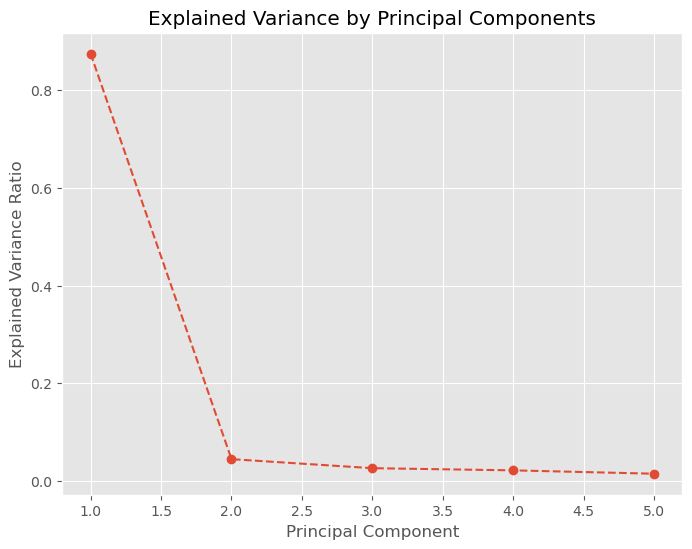

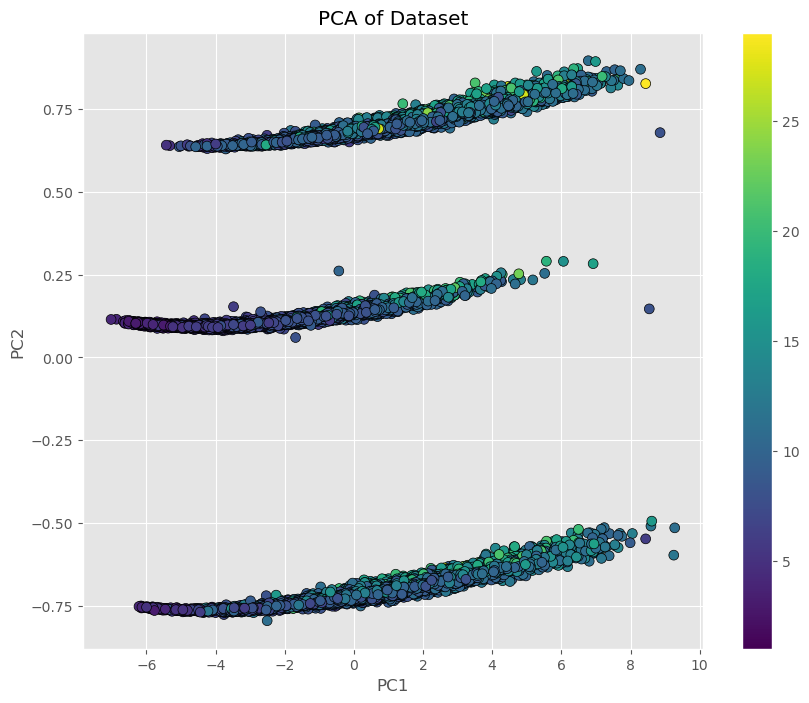

In [33]:
# PCA

# Calling the normalized data from the original dataset


# Perform PCA
pca_crab = PCA(n_components=5)
label_pca = pca_crab.fit_transform(X_pca)

# Explained variance ratio
explained_variance = pca_crab.explained_variance_ratio_

# plot the explained variance
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance,
          marker = 'o', linestyle = '--')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')

plt.show()

# Scatterplot of the first two principal components
plt.figure(figsize=(10,8))
plt.scatter(label_pca.iloc[:, 0], label_pca.iloc[:, 1], c = y_pca, cmap = 'viridis', edgecolor = 'k', s = 50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Dataset')
plt.colorbar()

plt.show()

# display the transformed data
# print(pd.DataFrame(X_pca)) # show the values of all PC

In [34]:
components = pca_crab.components_
components = cupy.asarray(components)
loadings = cupy.abs(components)
feature_names = X_pca.columns.to_list()
print(components.shape)

feature_importance_df = cudf.DataFrame(loadings, index=[f'PC{i+1}' for i in range(components.shape[0])], columns=feature_names)

print(feature_names)
print(len(feature_names))

print(feature_importance_df)

(5, 10)
['num__length', 'num__diameter', 'num__height', 'num__weight', 'num__shucked_weight', 'num__viscera_weight', 'num__shell_weight', 'cat__sex_F', 'cat__sex_I', 'cat__sex_M']
10
     num__length  num__diameter  num__height  num__weight  num__shucked_weight  num__viscera_weight  num__shell_weight  cat__sex_F  cat__sex_I  cat__sex_M
PC1     0.375801       0.376421     0.364145     0.380704             0.371055             0.374098           0.373311    0.064721    0.122551    0.057830
PC2     0.011349       0.009648     0.000925     0.015267             0.002973             0.020958           0.025091    0.648575    0.104369    0.752943
PC3     0.200276       0.214838     0.380309     0.268924             0.398908             0.282141           0.102919    0.341269    0.539931    0.198657
PC4     0.272631       0.261955     0.445326     0.170988             0.215216             0.233898           0.059712    0.349997    0.588014    0.238012
PC5     0.480208       0.433045     0.5382

In [35]:
print(label_pca.head(15))

           0         1         2         3         4
0   1.215727  0.159088  0.664530 -0.750214 -0.261634
1  -2.484868  0.103940  0.134217 -0.487213 -0.053464
2   0.577509 -0.714590 -0.268344  0.045601 -0.144470
3   4.933453  0.789276  0.562404  0.214974  0.523775
4  -0.306376  0.136865  0.698728 -0.453696 -0.111845
5   1.529107 -0.699190 -0.163503 -0.052591 -0.083226
6   1.406217 -0.689942  0.073043  0.237691 -0.323808
7  -0.663054  0.123409  0.151751 -0.853225 -0.095913
8   2.858057  0.728753  0.028380  0.090208 -0.045206
9  -2.627152 -0.752588 -0.480639  0.512998  0.048208
10 -3.582358  0.096646  0.286549 -0.108061 -0.080208
11 -0.416319  0.680239 -0.743752  0.078512  0.294481
12 -0.105031 -0.717839 -0.427062  0.066058  0.034660
13 -2.344266  0.103887  0.070751 -0.574635 -0.040357
14 -0.729344 -0.736279 -0.398503  0.195578 -0.321697


In [36]:
# split data 

# columns = label_pca.columns.to_list()

# for col in columns:
#     label_pca[col] = label_pca[col].astype('float32')

# call function to convert the features to float32
convert_float32(label_pca)

y = cudf.to_numeric(y_pca, errors='coerce').astype('float32')

print(type(y))


X_train, X_test, y_train, y_test = train_test_split(label_pca, y, test_size=0.2, random_state=42)



0    float32
1    float32
2    float32
3    float32
4    float32
dtype: object
<class 'cudf.core.series.Series'>


In [37]:

pca_compiled_scores = {}

In [38]:
%%time
# Random Forest

rf_pca = RandomForestRegressor()
rf_pca_model = rf_pca.fit(X_train, y_train)

get_scores(rf_pca_model, pca_compiled_scores)


    --------------------
    Performance Metrics: RandomForestRegressor()
    --------------------
        
    Mean Absolute Error (train): 1.0867
    Mean Absolute Error (test): 1.5175

    --------------------------------------------------

    Mean Squared Error (train): 2.3022
    Mean Squared Error (test): 4.8094

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.7710
    Coefficient of Determination (R2) (test): 0.5281

    --------------------------------------------------

    
CPU times: user 8.99 s, sys: 1.91 s, total: 10.9 s
Wall time: 2.44 s


In [39]:
%%time

# K Nearest Neighbours
knn_pca = KNeighborsRegressor()

knn_pca_model = knn_pca.fit(X_train, y_train)

get_scores(knn_pca, pca_compiled_scores)


    --------------------
    Performance Metrics: KNeighborsRegressor()
    --------------------
        
    Mean Absolute Error (train): 1.3515
    Mean Absolute Error (test): 1.6588

    --------------------------------------------------

    Mean Squared Error (train): 3.7780
    Mean Squared Error (test): 5.6246

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.6242
    Coefficient of Determination (R2) (test): 0.4481

    --------------------------------------------------

    
CPU times: user 237 ms, sys: 38.5 ms, total: 275 ms
Wall time: 282 ms


In [40]:
%%time

svr_pca = SVR()

svr_pca_model = svr_pca.fit(X_train, y_train)

get_scores(svr_pca_model, pca_compiled_scores)


    --------------------
    Performance Metrics: SVR()
    --------------------
        
    Mean Absolute Error (train): 1.4702
    Mean Absolute Error (test): 1.4784

    --------------------------------------------------

    Mean Squared Error (train): 5.0923
    Mean Squared Error (test): 5.0820

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.4935
    Coefficient of Determination (R2) (test): 0.5014

    --------------------------------------------------

    
CPU times: user 3.25 s, sys: 1.34 s, total: 4.59 s
Wall time: 4.64 s


In [41]:
%%time

# Catboost

cat_pca = CatBoostRegressor(task_type = 'GPU',
                        iterations = 1000,
                        learning_rate = 0.1,
                        verbose = False)

y_train_np = y_train.to_numpy()  # Convert cuDF Series to NumPy array

cat_pca_model = cat_pca.fit(X_train, y_train_np)

get_scores(cat_pca_model, pca_compiled_scores)


    --------------------
    Performance Metrics: <catboost.core.CatBoostRegressor object at 0x7fb90be493f0>
    --------------------
        
    Mean Absolute Error (train): 1.4112
    Mean Absolute Error (test): 1.4895

    --------------------------------------------------

    Mean Squared Error (train): 4.0950
    Mean Squared Error (test): 4.6362

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.5927
    Coefficient of Determination (R2) (test): 0.5451

    --------------------------------------------------

    
CPU times: user 16.2 s, sys: 6.01 s, total: 22.2 s
Wall time: 13.9 s


In [58]:
%%time

# Light Gradient Boosting Machine

params = {'objective': 'regression',
          'metric': 'mae',
          'boosting_type': 'gbdt', 
          'num_leaves': 31,
          'learning_rate': 0.1,
          'seed': 42,
          'force_col_wise': True
}

if isinstance(y_train, cudf.Series):
    y_train = y_train.to_numpy()
if isinstance(y_test, cudf.Series):
    y_test = y_test.to_numpy()
    
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

light_model = lgb.train(params, train_data, 100, valid_sets=[test_data])


light_pred_train = light_model.predict(X_train)
light_pred_test = light_model.predict(X_test)

# MAE
mae_train = float(mean_absolute_error(y_train, light_pred_train))
mae_test = float(mean_absolute_error(y_test, light_pred_test))

# MSE
mse_train = float(mean_squared_error(y_train, light_pred_train))
mse_test = float(mean_squared_error(y_test, light_pred_test))

# R2
r2_train = float(r2_score(y_train, light_pred_train))
r2_test = float(r2_score(y_test, light_pred_test))

print(f'''
{str('-')*20}
Performance Metrics: lightoost
{str('-')*20}
    
Mean Absolute Error (train): {mae_train:.4f}
Mean Absolute Error (test): {mae_test:.4f}

{str('-')*50}

Mean Squared Error (train): {mse_train:.4f}
Mean Squared Error (test): {mse_test:.4f}

{str('-')*50}

Coefficient of Determination (R2) (train): {r2_train:.4f}
Coefficient of Determination (R2) (test): {r2_test:.4f}

{str('-')*50}

''')

# add to compiled scores dict
pca_compiled_scores[str('lightGBM')] = {'MAE Train': mae_train,
                                                'MAE Test': mae_test,
                                                'MSE Train': mse_train,
                                                'MSE Test': mse_test,
                                                'R2 Train': r2_train,
                                                'R2 Test': r2_test}

[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 59240, number of used features: 5
[LightGBM] [Info] Start training from score 9.970172

--------------------
Performance Metrics: lightoost
--------------------
    
Mean Absolute Error (train): 1.4444
Mean Absolute Error (test): 1.5033

--------------------------------------------------

Mean Squared Error (train): 4.3254
Mean Squared Error (test): 4.6859

--------------------------------------------------

Coefficient of Determination (R2) (train): 0.5698
Coefficient of Determination (R2) (test): 0.5402

--------------------------------------------------


CPU times: user 27 s, sys: 2.03 s, total: 29 s
Wall time: 2.48 s


In [59]:
%%time

# XGBoost

# Convert data to GPU dataframes
X_train_gpu, y_train_gpu = cudf.DataFrame(X_train), cudf.Series(y_train)
X_test_gpu, y_test_gpu = cudf.DataFrame(X_test), cudf.Series(y_test)

# Create DMatrix
dtrain = xgb.DMatrix(X_train_gpu, label=y_train_gpu)
dtest = xgb.DMatrix(X_test_gpu, label=y_test_gpu)


# xgb_model = xgb.XGBRegressor(
#             device = 'cuda',  # Using GPU
#             booster = 'gbtree',
#             random_state=42
#             )

params = {'device': 'cuda',
          'booster': 'gbtree',
          'random_state': 42}

xgb_model = xgb.train(params, dtrain, num_boost_round = 100)

xg_pred_train = xgb_model.predict(dtrain)
xg_pred_test = xgb_model.predict(dtest)

# MAE
mae_train = float(mean_absolute_error(y_train_gpu, xg_pred_train))
mae_test = float(mean_absolute_error(y_test_gpu, xg_pred_test))

# MSE
mse_train = float(mean_squared_error(y_train_gpu, xg_pred_train))
mse_test = float(mean_squared_error(y_test_gpu, xg_pred_test))

# R2
r2_train = float(r2_score(y_train_gpu, xg_pred_train))
r2_test = float(r2_score(y_test_gpu, xg_pred_test))

print(f'''
{str('-')*20}
Performance Metrics: XGBoost
{str('-')*20}
    
Mean Absolute Error (train): {mae_train:.4f}
Mean Absolute Error (test): {mae_test:.4f}

{str('-')*50}

Mean Squared Error (train): {mse_train:.4f}
Mean Squared Error (test): {mse_test:.4f}

{str('-')*50}

Coefficient of Determination (R2) (train): {r2_train:.4f}
Coefficient of Determination (R2) (test): {r2_test:.4f}

{str('-')*50}

''')

# add to compiled scores dict
pca_compiled_scores[str('XGBoost')] = {'MAE Train': mae_train,
                        'MAE Test': mae_test,
                        'MSE Train': mse_train,
                        'MSE Test': mse_test,
                        'R2 Train': r2_train,
                        'R2 Test': r2_test}




--------------------
Performance Metrics: XGBoost
--------------------
    
Mean Absolute Error (train): 1.3197
Mean Absolute Error (test): 1.5038

--------------------------------------------------

Mean Squared Error (train): 3.5517
Mean Squared Error (test): 4.7619

--------------------------------------------------

Coefficient of Determination (R2) (train): 0.6467
Coefficient of Determination (R2) (test): 0.5328

--------------------------------------------------


CPU times: user 1.13 s, sys: 212 ms, total: 1.34 s
Wall time: 792 ms


In [60]:
pca_compiled_scores_df = pd.DataFrame(pca_compiled_scores)

list_of_models = ['Random Forest', 'K-Nearest Neighbours',
                  'Support Vector Machine', 'Catboost', 'LightGBM', 'XGBoost']

# rename the name of models in df
pca_compiled_scores_df.columns = list_of_models[:len(pca_compiled_scores_df.columns)]

print(pca_compiled_scores_df)
    

           Random Forest  K-Nearest Neighbours  Support Vector Machine  Catboost  LightGBM   XGBoost
MAE Train       1.086656              1.351543                1.470216  1.411208  1.319690  1.444370
MAE Test        1.517475              1.658781                1.478441  1.489519  1.503808  1.503288
MSE Train       2.302216              3.778030                5.092316  4.094994  3.551707  4.325356
MSE Test        4.809391              5.624574                5.081964  4.636210  4.761920  4.685948
R2 Train        0.771019              0.624233                0.493513  0.592708  0.646744  0.569796
R2 Test         0.528101              0.448115                0.501356  0.545093  0.532759  0.540213


In [61]:
print(base_compiled_scores_df)
print(featured_compiled_results_df)
print(pca_compiled_scores_df)

           Random Forest  K-Nearest Neighbours  Support Vector Machine  Catboost  LightGBM   XGBoost
MAE Train       1.014681              1.269082                1.376891  1.306964  1.350002  1.254670
MAE Test        1.424126              1.542975                1.382103  1.406616  1.406531  1.421196
MSE Train       1.995749              3.366018                4.390152  3.515494  3.808062  3.232952
MSE Test        4.241337              5.004041                4.379949  4.157457  4.151804  4.248526
R2 Train        0.801501              0.665213                0.563351  0.650345  0.621246  0.678447
R2 Test         0.583839              0.509002                0.570238  0.592069  0.592624  0.583133
           Random Forest  K-Nearest Neighbours  Support Vector Machine  Catboost  LightGBM   XGBoost
MAE Train       0.989710              1.282475                1.448527  1.295303  1.343294  1.223107
MAE Test        1.421312              1.561637                1.457175  1.409969  1.408710 

### END-OF-GPU-PCA
---

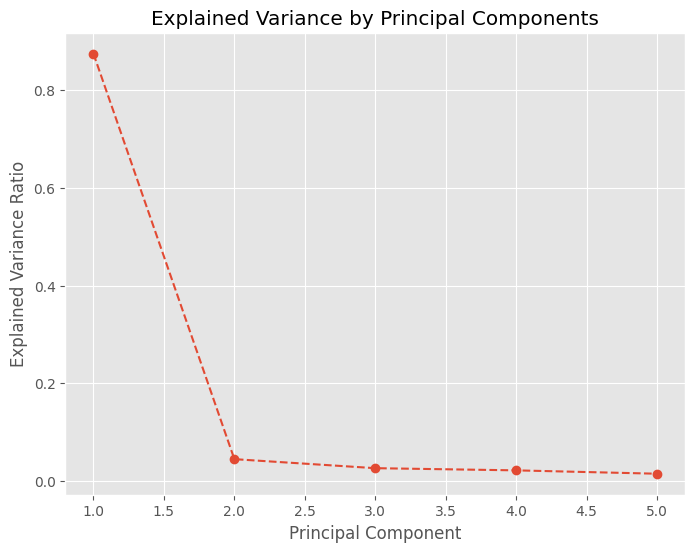

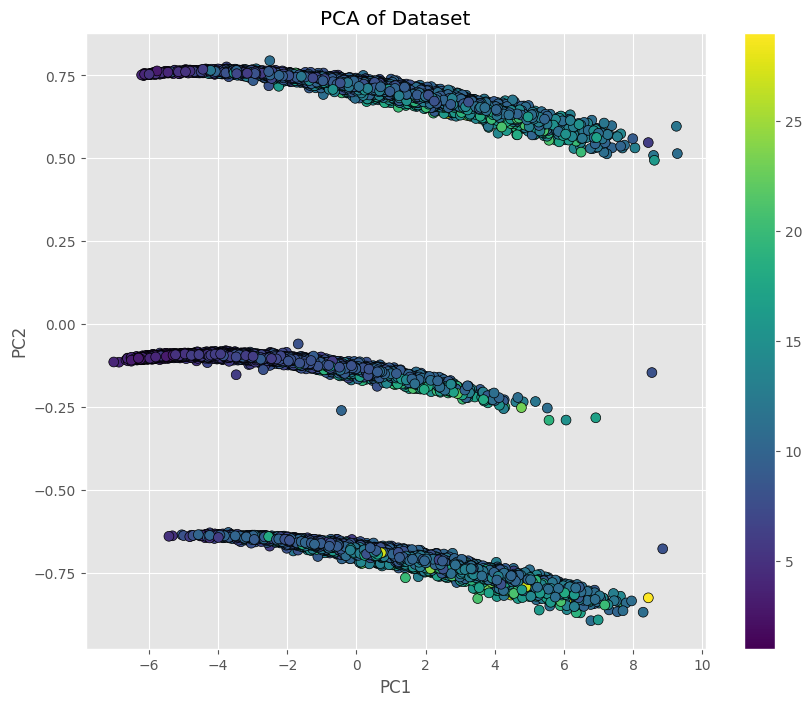

In [64]:
# PCA


# Seperating the target and response variables
y = scaled_df['age'] # target variable
X = scaled_df.iloc[:, :-1] # independent variable

# Perform PCA
pca_crab = PCA(n_components=5)
X_pca = pca_crab.fit_transform(X)

# Explained variance ratio
explained_variance = pca_crab.explained_variance_ratio_

# plot the explained variance
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance,
          marker = 'o', linestyle = '--')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')

plt.show()

# Scatterplot of the first two principal components
plt.figure(figsize=(10,8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y, cmap = 'viridis', edgecolor = 'k', s = 50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Dataset')
plt.colorbar()

plt.show()

# display the transformed data
# print(pd.DataFrame(X_pca)) # show the values of all PC

In [18]:
print(feature_names)
print(len(feature_names))

NameError: name 'feature_names' is not defined

In [66]:
components = pca_crab.components_
loadings = np.abs(components)
feature_names = X.columns.to_list()
print(components.shape)

feature_importance_df = pd.DataFrame(loadings, index=[f'PC{i+1}' for i in range(components.shape[0])], columns=feature_names)

(5, 10)


In [67]:
print(feature_importance_df)

     num__length  num__diameter  num__height  num__weight  num__shucked_weight  num__viscera_weight  num__shell_weight  cat__sex_F  cat__sex_I  cat__sex_M
PC1     0.375801       0.376421     0.364145     0.380704             0.371055             0.374098           0.373311    0.064721    0.122551    0.057830
PC2     0.011349       0.009648     0.000925     0.015267             0.002973             0.020958           0.025091    0.648576    0.104368    0.752943
PC3     0.200279       0.214841     0.380313     0.268926             0.398911             0.282143           0.102919    0.341267    0.539924    0.198657
PC4     0.272629       0.261954     0.445322     0.170985             0.215212             0.233896           0.059711    0.350002    0.588018    0.238016
PC5     0.480208       0.433044     0.538286     0.090943             0.243852             0.088464           0.464090    0.027980    0.015720    0.012261


### Linear Regression with PCA


In [68]:
# using helpers to get cv results

linreg = LinearRegression()

linreg_pca = helpers.get_cv_results(linreg, X_pca, y,5)

print(linreg_pca)

Cross Validation Results:
fit_time [0.01837301 0.00449085 0.00730109 0.0045259  0.00440502]
score_time [0.00224996 0.00296617 0.0019269  0.00062203 0.00063109]
test_neg_mean_absolute_error [-1.57832921 -1.60054292 -1.57639885 -1.59455539 -1.58413189]
train_neg_mean_absolute_error [-1.58913208 -1.58193795 -1.58965196 -1.58407778 -1.58868802]
test_neg_mean_squared_error [-5.09958079 -5.38275332 -5.05444166 -5.39571482 -5.10840605]
train_neg_mean_squared_error [-5.22905012 -5.15894657 -5.24089676 -5.15572948 -5.22703609]
test_r2 [0.4916586  0.47347461 0.49620498 0.4699074  0.48614425]
train_r2 [0.48197268 0.48648238 0.48078688 0.48736677 0.48332584]
None


In [69]:
xgb_model = xgb.XGBRegressor()


xgb_pca = helpers.get_cv_results(xgb_model, X_pca, y, 5)

print(xgb_pca)

KeyboardInterrupt: 